# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Загрузка данных
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
def get_info(data: pd.DataFrame):
    display(data.head())
    print('\n INFO\n')
    display(data.info())
    print('\n Дупликаты общие \n')
    display(data[data.duplicated()])
    print('\n Пропущенные данные в % \n')
    display(data.isna().mean()*100)
    display(data.describe(include='all'))

In [4]:
get_info(data)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



 INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None


 Дупликаты общие 



,file_name,real_age



 Пропущенные данные в % 



file_name    0.0
real_age     0.0
dtype: float64

,file_name,real_age
count,7591,7591.000000
unique,7591,NaN
top,002713.jpg,NaN
freq,1,NaN
mean,NaN,31.201159
std,NaN,17.145060
min,NaN,1.000000
25%,NaN,20.000000
50%,NaN,29.000000
75%,NaN,41.000000


7591 фоток

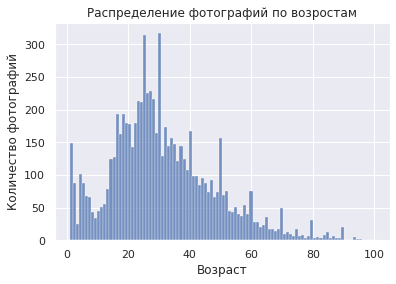

In [7]:
sns.set(style="darkgrid")
sns.histplot(data=data, x="real_age", bins=100).set(title='Распределение фотографий по возростам', 
                                                    xlabel='Возраст', ylabel='Количество фотографий')
plt.show()

In [12]:
print('min age', data['real_age'].min())
print('max age', data['real_age'].max())

min age 1
max age 100


In [30]:
print('Пики на график \n')
group = data.groupby('real_age').count().rename(columns={'file_name': 'count'})
group[group['count'] > 300]

Пики на график 



,count
real_age,
25,315
30,317


Модель, думаю, будет хорошо определять людей с возростом, который находится в пике распределения. Это около 23-25 лет. Там где плотность меньше, модель будет хуже определять

In [8]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


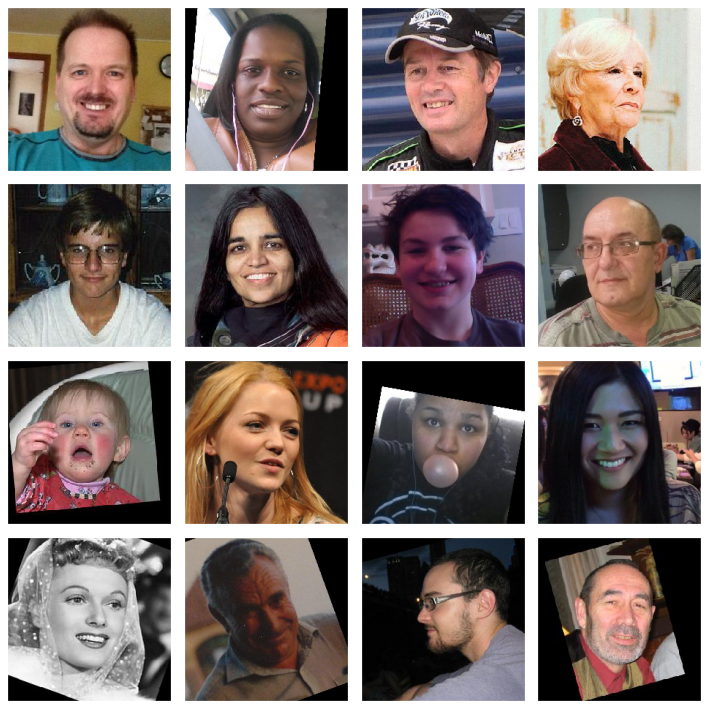

In [9]:
features, target = next(gen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

- Размер датасета не слишком большой, чтобы решать задачу регрессии. Следует применять аугментацию.
- Минимальный возраст в датасете - 1, максимальный - 100. Большая часть фоток сконцентрирована в диапазоне от ~ 15 до ~ 40 лет. Всплески приходят на 25 и 30 лет.
- В датасете присутсвуют черно-белые фотографии, посторонние предметы(то есть лица плохо видно), некоторые преобразования(фото повернуты).
- Рекомендованная аугментация: отражение по горизонтали, повороты до 10-15 градусов, сдвиги фотографий по вертикали и по горизонатали на 10-15 процентов.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanAbsoluteError
import pandas as pd


def load_train(path):
    data = pd.read_csv(path+'/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       # horizontal_flip=True,
                                       # vertical_flip=True,
                                       rotation_range=90,
                                       width_shift_range=0.15,
                                       height_shift_range=0.15,
                                       rescale=1. / 255,
                                       )
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345)
    return train_gen_flow

def load_test(path):
    data = pd.read_csv(path + '/labels.csv')
    validation_datagen = ImageDataGenerator(validation_split=0.25,
                                            rescale=1. / 255)
    val_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=data,
        directory=path+'/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345)
    return val_gen_flow



def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=[MeanAbsoluteError()])
    print(model.summary())
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=12,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
resnet50 (Model)             (None, 7, 7, 2048)        23587712
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0
_________________________________________________________________
dense (Dense)                (None, 256)               524544
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129
=================================================================
Total params: 24,145,281
Trainable params: 24,092,161
Non-trainable params: 53,120
_________________________________________________________________
Train for 178 steps, validate for 60 steps
Epoch 1/12
178/178 - 99s - loss: 267.0548 - mean_absolute_error: 12.1027 - val_loss: 522.6933 - val_mean_absolute_error: 17.7889
Epoch 2/12
178/178 - 93s - loss: 126.5345 - mean_absolute_error: 8.5949 - val_loss: 414.5788 - val_mean_absolute_error: 15.2275
Epoch 3/12
178/178 - 93s - loss: 109.3136 - mean_absolute_error: 7.9373 - val_loss: 276.5997 - val_mean_absolute_error: 12.2132
Epoch 4/12
178/178 - 93s - loss: 89.6280 - mean_absolute_error: 7.2230 - val_loss: 150.0921 - val_mean_absolute_error: 9.2897
Epoch 5/12
178/178 - 94s - loss: 76.3664 - mean_absolute_error: 6.7538 - val_loss: 105.2955 - val_mean_absolute_error: 8.0041
Epoch 6/12
178/178 - 98s - loss: 71.1961 - mean_absolute_error: 6.3927 - val_loss: 98.7719 - val_mean_absolute_error: 7.4441
Epoch 7/12
178/178 - 97s - loss: 65.4612 - mean_absolute_error: 6.1814 - val_loss: 80.5325 - val_mean_absolute_error: 6.6462
Epoch 8/12
178/178 - 97s - loss: 53.7010 - mean_absolute_error: 5.6410 - val_loss: 93.4783 - val_mean_absolute_error: 7.3391
Epoch 9/12
178/178 - 98s - loss: 50.9078 - mean_absolute_error: 5.4956 - val_loss: 147.4487 - val_mean_absolute_error: 9.4019
Epoch 10/12
178/178 - 97s - loss: 49.2380 - mean_absolute_error: 5.3812 - val_loss: 100.2634 - val_mean_absolute_error: 7.7773
Epoch 11/12
178/178 - 98s - loss: 42.9721 - mean_absolute_error: 5.0502 - val_loss: 116.7104 - val_mean_absolute_error: 7.9671
Epoch 12/12
178/178 - 96s - loss: 42.2400 - mean_absolute_error: 4.9755 - val_loss: 80.4625 - val_mean_absolute_error: 6.6111
60/60 - 10s - loss: 80.4625 - mean_absolute_error: 6.6111
Test MAE: 6.6111

```

## Анализ обученной модели

Нам удалось получить модель, у которой **средняя ошибка по модулю равна 6.6111**.
Loss во время обучения падал, но в валидации loss какое-то время вырастал.
В среднем на обучение уходило 95 секунд.
ResNet здесь хорошо сыграл свою роль)